# Mastering PyTorch

## Supervised learning

### Tune the training with a cusom loss

#### Accompanying notebook to Video 1.4

In [1]:
# Include libraries

import numpy as np
from PIL import Image

import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torchvision import transforms
import torchvision.transforms.functional as TF

from utils import get_image_name, get_number_of_cells, \
     split_data, download_data, SEED

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
root = './'
download_data(root=root)

data_paths = os.path.join('./', 'data_paths.txt')
if not os.path.exists(data_paths):
  !wget http://pbialecki.de/mastering_pytorch/data_paths.txt

if not os.path.isfile(data_paths):
    print('data_paths.txt missing!')

In [3]:
# Setup Globals
use_cuda = torch.cuda.is_available()
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
    print('Using: {}'.format(torch.cuda.get_device_name(0)))
print_steps = 10

Using: GeForce GTX 1070


In [4]:
# Utility functions
def weights_init(m):
    '''
    Initialize the weights of each Conv2d layer using xavier_uniform
    ("Understanding the difficulty of training deep feedforward
    neural networks" - Glorot, X. & Bengio, Y. (2010))
    '''
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform(m.weight.data)
        m.bias.data.zero_()
    if isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform(m.weight.data)
        m.bias.data.zero_()

In [5]:
class CellDataset(Dataset):
    def __init__(self, image_paths, target_paths, size, train=False):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.size = size
        resize_size = [s+10 for s in self.size]
        self.resize_image = transforms.Resize(
            size=resize_size, interpolation=Image.BILINEAR)
        self.resize_mask = transforms.Resize(
            size=resize_size, interpolation=Image.NEAREST)
        self.train = train
        
    def transform(self, image, mask):
        # Resize
        image = self.resize_image(image)
        mask = self.resize_mask(mask)
        
        # Perform data augmentation
        if self.train:            
            # Random cropping
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=self.size)
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)
            
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
        else:
            center_crop = transforms.CenterCrop(self.size)
            image = center_crop(image)
            mask = center_crop(mask)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [6]:
def get_random_sample(dataset):
    '''
    Get a random sample from the specified dataset.
    '''
    data, target = dataset[int(np.random.choice(len(dataset), 1))]
    data.unsqueeze_(0)
    target.unsqueeze_(0)
    if use_cuda:
        data = data.cuda()
        target = target.cuda()
    data = Variable(data)
    target = Variable(target)
    return data, target

In [7]:
class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding,
                               stride)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                               padding, stride)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, padding, stride)
            )

    def forward(self, x):
        residual = x
        out = self.act(self.conv1(x))
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.act(out)
        return out

In [8]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size,
                                   padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x

In [9]:
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels,
                 kernel_size, padding, stride):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x

In [10]:
class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(ResUNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size, padding, stride)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size,
                              padding, stride)

        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size,
                              padding, stride)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size,
                              padding, stride)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,
                          kernel_size, padding, stride)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels,
                          kernel_size, padding, stride)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels,
                          kernel_size, padding, stride)

        self.out = nn.Conv2d(out_channels, 1, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = F.sigmoid(self.out(x_up))
        return x_out

In [11]:
def train(epoch):
    '''
    Main training loop
    '''
    # Set model to train mode
    model.train()
    # Iterate training set
    for batch_idx, (data, mask) in enumerate(train_loader):
        if use_cuda:
            data = data.cuda()
            mask = mask.cuda()
        data = Variable(data)
        mask = Variable(mask.squeeze())
        optimizer.zero_grad()
        output = model(data)
        loss_mask = criterion(output.squeeze(), mask)
        loss_dice = dice_loss(mask, output.squeeze())
        loss = loss_mask + loss_dice
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_steps == 0:
            loss_mask_data = loss_mask.data[0]
            loss_dice_data = loss_dice.data[0]
            train_losses.append(loss_mask_data)
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss(dice): {:.6f}'.
                format(epoch, batch_idx * len(data),
                       len(train_loader.dataset), 100. * batch_idx / len(
                           train_loader), loss_mask_data, loss_dice_data))

In [12]:
def validate():
    '''
    Validation loop
    '''
    # Set model to eval mode
    model.eval()
    # Setup val_loss
    val_mask_loss = 0
    val_dice_loss = 0
    # Disable gradients (to save memory)
    with torch.no_grad():
        # Iterate validation set
        for data, mask in val_loader:
            if use_cuda:
                data = data.cuda()
                mask = mask.cuda()
            data = Variable(data)
            mask = Variable(mask.squeeze())
            output = model(data)
            val_mask_loss += F.binary_cross_entropy(output.squeeze(), mask).data[0]
            val_dice_loss += dice_loss(mask, output.squeeze()).data[0]
    # Calculate mean of validation loss
    val_mask_loss /= len(val_loader)
    val_dice_loss /= len(val_loader)
    val_losses.append(val_mask_loss)
    print('Validation\tLoss: {:.6f}\tLoss(dice): {:.6f}'.format(val_mask_loss, val_dice_loss))

In [13]:
# Get train data folders and split to training / validation set
with open(data_paths, 'r') as f:
    data_paths = f.readlines()
image_paths = [line.split(',')[0].strip() for line in data_paths]
target_paths = [line.split(',')[1].strip() for line in data_paths]

# Split data into train/validation datasets
im_path_train, im_path_val, tar_path_train, tar_path_val = split_data(
    image_paths, target_paths)

In [14]:
# Create datasets
train_dataset = CellDataset(
    image_paths=im_path_train,
    target_paths=tar_path_train,
    size=(96, 96),
    train=True
)
val_dataset = CellDataset(
    image_paths=im_path_val,
    target_paths=tar_path_val,
    size=(96, 96),
    train=False
)

# Wrap in DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    num_workers=12,
    shuffle=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    num_workers=12,
    shuffle=True
)

In [15]:
# Creae model
model = ResUNet(
    in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
# Initialize weights
model.apply(weights_init)
# Push to GPU, if available
if use_cuda:
    model.cuda()

In [16]:
# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=1e-3)
# Create criterion
criterion = nn.BCELoss()

#### Dice coefficient

Calculate the dice coefficient.

Divide the "overlap" between the predicted and the ground truth mask by
the total size of the two objects.

\begin{align}
QS = \frac{2|X \cap Y|}{|X| + |Y|}
\end{align}

In [17]:
def dice_loss(y_target, y_pred, smooth=0.0):
    y_target = y_target.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_target * y_pred).sum()
    dice_coef = (2. * intersection + smooth) / (
        y_target.sum() + y_pred.sum() + smooth)
    return 1. - dice_coef

In [18]:
# Start training
train_losses, val_losses = [], []
epochs = 30
for epoch in range(1, epochs):
    train(epoch)
    validate()

Train Epoch: 1 [0/8640 (0%)]	Loss: 0.699599	Loss(dice): 0.543329
Train Epoch: 1 [320/8640 (4%)]	Loss: 0.696598	Loss(dice): 0.570614
Train Epoch: 1 [640/8640 (7%)]	Loss: 0.694466	Loss(dice): 0.572270
Train Epoch: 1 [960/8640 (11%)]	Loss: 0.692294	Loss(dice): 0.557642
Train Epoch: 1 [1280/8640 (15%)]	Loss: 0.690054	Loss(dice): 0.569296
Train Epoch: 1 [1600/8640 (19%)]	Loss: 0.688195	Loss(dice): 0.593345
Train Epoch: 1 [1920/8640 (22%)]	Loss: 0.685780	Loss(dice): 0.561944
Train Epoch: 1 [2240/8640 (26%)]	Loss: 0.683014	Loss(dice): 0.541047
Train Epoch: 1 [2560/8640 (30%)]	Loss: 0.680977	Loss(dice): 0.548185
Train Epoch: 1 [2880/8640 (33%)]	Loss: 0.678386	Loss(dice): 0.539473
Train Epoch: 1 [3200/8640 (37%)]	Loss: 0.677251	Loss(dice): 0.552792
Train Epoch: 1 [3520/8640 (41%)]	Loss: 0.675643	Loss(dice): 0.565948
Train Epoch: 1 [3840/8640 (44%)]	Loss: 0.676324	Loss(dice): 0.610439
Train Epoch: 1 [4160/8640 (48%)]	Loss: 0.672479	Loss(dice): 0.575281
Train Epoch: 1 [4480/8640 (52%)]	Loss: 0.66

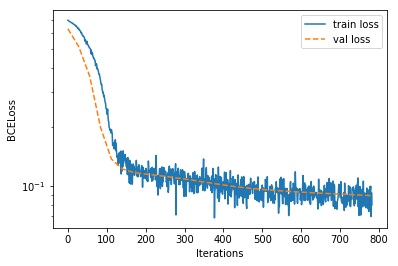

In [19]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

val_indices = np.linspace(0, (epochs-1)*len(train_loader)/print_steps, epochs-1)

plt.plot(train_losses, '-', label='train loss')
plt.plot(val_indices, val_losses, '--', label='val loss')
plt.yscale("log", nonposy='clip')
plt.xlabel('Iterations')
plt.ylabel('BCELoss')
plt.legend()
plt.show()

In [23]:
val_data, val_target = get_random_sample(val_dataset)

In [24]:
val_pred = model(val_data)
val_pred_arr = val_pred.data.cpu().squeeze_().numpy()
val_target_arr = val_target.data.cpu().squeeze_().numpy()

Text(0.5,1,u'Absolute error')

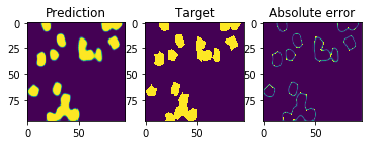

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(val_pred_arr)
ax1.set_title('Prediction')
ax2.imshow(val_target_arr)
ax2.set_title('Target')
ax3.imshow(np.abs(val_pred_arr - val_target_arr))
ax3.set_title('Absolute error')